This script calculates an airfoil and outputs it to a format to be read by gmsh works for gmsh 4.7.1

In [1]:
#import common modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# import fish utility modules
import airfoil as ar

from scipy import optimize

First we specify the thickness and chord length and then call the naca4 function in `airfoil.py`.  The format for that function is naca4(x_coordinates, thickness, camber, location of max thickness, closed trailing edge, chord length)  

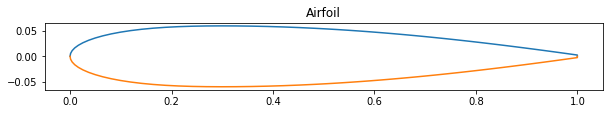

In [10]:
chord = 1.0                         # chord
num_points = 50                   # number of points
half_points = int(num_points/2)     # half the points for spacing
p = 0.3                             # location of maximum camber
# half-cosine spacing
beta = np.linspace(0, np.pi, num_points)
dx1 = (0.5*(1-np.cos(beta)))
dx1 = dx1[0:half_points]
# uniform spacing
dx2 = np.linspace(dx1[-1], chord, half_points)
dx = np.append(dx1, dx2[1::])

t = 0.12   # thickness
m = 0.0    # camber

modified_foil = True

# call the functoin
if modified_foil:
    TE = 0.0025  # trailing edge
    x, y = ar.naca4_modified(dx, t, p, TE, chord)
    
    # find the trailing edge connection point
    point_x = x[0][-1]
    point_y = 0
    
    #convert coordinates to upper and lower arrays
    xu = np.append(x[0], point_x) 
    xl = np.append(x[1], point_x)
    yu = np.append(y[0], point_y)
    yl = np.append(y[1], point_y)
else:
    TE = True  # trailing edge
    x, y = ar.naca4(dx, t, m, p, TE, chord)

    #convert coordinates to upper and lower arrays
    xu = x[0]
    xl = x[1]
    yu = y[0]
    yl = y[1]



# plot the results
f1, ax1 = plt.subplots(figsize=(10,20))
ax1.plot(xu, yu)
ax1.plot(xl, yl)
ax1.set_title('Airfoil')
ax1.set_aspect('equal')

Write to a .geo file

In [11]:
# Create array for writing
coord_points = len(xu)
point = np.zeros((2*coord_points-2,3))
ind = 0
back_plane = -0.1

point[0:coord_points, 0] = xu
point[0:coord_points, 1] = yu
point[0:coord_points, 2] = back_plane

point[coord_points:, 0] = np.flipud(xl[1:-1])
point[coord_points:, 1] = np.flipud(yl[1:-1])
point[coord_points:, 2] = back_plane

num_points = point.shape[0]
airfoil_point_numbers = np.arange(1, num_points, 1)
num_lines = num_points

We can make things easier by defining a characteristic length for the mesh and a fluid domain based on the geometry

In this case:

all variables are a factor of total length e.g. 40 is 40 * length of airfoil

Lx_plus = length behind the airfoil

Lx_minus = length in front of airfoil

Ly = length top and bottom of airfoil

In [24]:
# Define our setup variables
U = 1.0                                 # Freestream Velocity
L = 1.0                                 # Length            
density = 1027                          # fluid density
kinVisc = 2.5e-11                       # kinematic viscosity of fluid
dynamicVisc = density * kinVisc         # dynamic viscosity of fluid
yPlus = 3.0                             # desired Y+
growth_ratio = 1.12                     # growth ratio
N = 20                                  # number of inflation layers

Lx_plus = 1.5
Lx_minus = -0.5
Ly_plus = 0.5
Ly_minus = -0.5 

# fluid wall refinement
suction_cl = 0.0025
pressure_cl = 0.0025
le_cl = 0.001
te_cl = 0.001
wall_cl = 0.03 
back_plane = -0.5

# airfoil wall refinement
airfoil_num_elements = 450

# airfoil boundary layer
hfar = 1.77e-03
hwall_n = 3.75e-05
thickness = 1.62e-02
growth_ratio = 1.12

# extrude distance
extrude_length = 1

In [25]:
#Write data to the .geo file
with open('airfoil_round.geo', 'w') as df:
    # first we write the variables for easy changing locally later
    # df.write('airfoil_num_elements = %f;\n' % (airfoil_num_elements))
    df.write('ss_cl =  %f;\n' % (suction_cl))
    df.write('ps_cl =  %f;\n' % (pressure_cl))
    df.write('le_cl = %f;\n' % (le_cl))
    df.write('te_cl = %f;\n' % (te_cl))
    df.write('wall_cl =  %f;\n' % (wall_cl))
    df.write('extrude_length =  %f;\n' % (extrude_length))
    df.write('\n')
    df.write('Lx_plus = %f;\n' % (Lx_plus * chord))
    df.write('Lx_minus = %f;\n' % (Lx_minus * chord))
    df.write('Ly_plus = %f;\n' % (Ly_plus * chord))
    df.write('Ly_minus = %f;\n' % (Ly_minus * chord))
    df.write('\n')
    df.write('back_plane = %f;\n' % (back_plane))
    df.write('\n')

    for i in np.arange(0, num_points, 1):
        if point[i,0] >= 0.95:
            df.write('Point(%i) = {%f, %f, back_plane, te_cl};\n' % (i+1, point[i,0], point[i,1]))
        elif point[i, 0] <= 0.004:
            df.write('Point(%i) = {%f, %f, back_plane, le_cl};\n' % (i+1, point[i,0], point[i,1]))
        elif i <= num_points/2:
            df.write('Point(%i) = {%f, %f, back_plane, ss_cl};\n' % (i+1, point[i,0], point[i,1]))
        else:
            df.write('Point(%i) = {%f, %f, back_plane, ps_cl};\n' % (i+1, point[i,0], point[i,1]))
    df.write('\n')
    
    # define the domain point numbers and domain line numbers
    domain_points = np.arange(num_points + 1, num_points + 5, 1)
    domain_lines = np.arange(num_lines + 1, num_lines + 5, 1)
    line_loops = np.array([101, 102])
    plane_surface = np.array([201])
    
    # write the fluid domain points
    df.write('// Define bounding box corners for fluid domain \n')        
    df.write('Point(%i) = {Lx_minus, Ly_minus, back_plane, wall_cl};\n' % (domain_points[0]))
    df.write('Point(%i) = {Lx_minus, Ly_plus, back_plane, wall_cl};\n' % (domain_points[1]))
    df.write('Point(%i) = {Lx_plus, Ly_plus, back_plane, wall_cl};\n' % (domain_points[2]))
    df.write('Point(%i) = {Lx_plus, Ly_minus, back_plane, wall_cl};\n' % (domain_points[3]))
    df.write('\n')
    
    # write the fluid domain lines
    df.write('// Make line loops for the fluid domain\n')
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[0], domain_points[0], domain_points[1]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[1], domain_points[1], domain_points[2]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[2], domain_points[2], domain_points[3]))
    df.write('Line(%i) = {%i, %i};\n' % (domain_lines[3], domain_points[3], domain_points[0]))
    df.write('\n')
    
    # combine the loops into a surface
    df.write('// Combine the fluid domain lines\n')
    df.write('Line Loop(' + str(line_loops[0]) + ') = {' + np.array2string(domain_lines, separator = ', ').strip('[]') + '}; \n')
    
    df.write('\n')
    df.write('// combine foil points into a bspline \n')
    df.write('BSpline(5) = {'  + str(airfoil_point_numbers[0]) + ':' + str(coord_points) + '}; \n')
    df.write('BSpline(6) = {' + str(coord_points) + ':' + str(num_points) + ',' +  str(airfoil_point_numbers[0]) + '}; \n')
    df.write('Line Loop(' + str(line_loops[1]) + ') = {5, 6}; \n') 
    df.write('\n')

    # df.write('Transfinite Curve {5} = airfoil_num_elements Using Progression 1; \n')
    # df.write('Transfinite Curve {6} = airfoil_num_elements Using Progression 1; \n')
    # df.write('\n')
    
    df.write('Plane Surface(' + str(plane_surface[0]) + ') = {101, 102}; \n')
    df.write('\n')
    
    # df.write('Transfinite Curve {400, 402} = fluid_top Using Progression 1; \n')
    # df.write('Transfinite Curve {399, 401} = fluid_bottom Using Progression 1; \n')

    # attempts for hex cells, comment for tet cells
    df.write('//Recombine Surface {' + str(plane_surface[0]) + '}; \n')

    df.write('\n')
    # extrude the surface so we can name the boundaries
    df.write('Extrude {0, 0, extrude_length} {\n Surface{' + str(plane_surface[0]) + '};\n Layers{1};\n Recombine;\n}')
    df.write('\n')

    #define the physical surface patches
    df.write('// Define the physical surfaces -> values are obtained via the GUI \n')
    df.write('Physical Surface("inlet") = {212}; \n')
    df.write('Physical Surface("outlet") = {220}; \n')
    df.write('Physical Surface("symFront") = {233}; \n')
    df.write('Physical Surface("symBack") = {201}; \n')
    df.write('Physical Surface("topAndBottom") = {216, 224}; \n')
    df.write('Physical Surface("wingT") = {232}; \n')
    df.write('Physical Surface("wingB") = {228}; \n')
    df.write('\n')

    # define the internal volume
    df.write('// Define the internal volume - usually 1 but obtained from GUI \n')
    df.write('Physical Volume("internal") = {1};\n')
    df.write('\n')

    # define the boundary layer addition
    df.write('//Define the boundary layer \n')
    df.write('Field[1] = BoundaryLayer; \n')
    df.write('Field[1].EdgesList = {5, 6}; \n')
    df.write('Field[1].hfar = ' + str(hfar) + '; \n')
    df.write('Field[1].hwall_n = ' + str(hwall_n) + '; \n')
    df.write('Field[1].thickness = ' + str(thickness) + '; \n')
    df.write('Field[1].ratio = ' + str(growth_ratio) + '; \n')
    df.write('Field[1].AnisoMax = 10; \n')
    df.write('Field[1].Quads = 1; \n')
    df.write('Field[1].IntersectMetrics = 0; \n')
    df.write('BoundaryLayer Field = 1; \n')